<font color='red'>Observacions:


- Valors de mDice, és la micro-average Dice comptant també els resultats de la "classe" background  
(Micro-averaging gives equal weight to every instance and shows average performance across all predictions.)
- La reducció d'imatges no és massa significativa (Train passa de 45623 img a 44447, reducció del 2,6%)
- La reducció del nombre d'annotations és molt significativa (Train passa de 333401 annot a 124803, reducció del 62,6%)

**ToDo:**
* Pujar la carpeta "_logs" a la carpeta "_data"   
    He trobat aquests arxius:
    * results_pointrend_4epoch_8bs_192ir_ade
    * DMNET_4epoch_noCrop_City
    * DMNet_4epoch_crop_City


* Pujar l'arxiu "area_ratio_foreground.csv" a la carpeta "fashionpedia/"  
(Aquest arxiu amb area ratios, counts, ... l'he generat a partir amb el notebook "Task 1 - DataAnalysis")

stats_file = f"{fashion_dir}/area_ratio_foreground.csv"


</font>

# Data reduction

## Imports and utility functions


In [2]:

# Select local or Google Colab environment
# ---------------------------------------------------------------------------
env = ["local", "colab"][0]
print(f"Selected Environment: {env}")

# ---------------------------------------------------------------------------
if env == "colab":
    from google.colab import drive # type: ignore
    drive.mount('/content/drive')
    data_dir = "/content/drive/MyDrive/OR/P2/_data/"
    src_dir = "/content/drive/MyDrive/OR/P2/src/"
    
elif env == "local":
    src_dir = "../src"
    data_dir = "../_data/"

# ---------------------------------------------------------------------------

%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
from fashionpedia.fp import Fashionpedia
import glob

sys.path.append(src_dir)
from utils.log_results import read_log_results
from utils.data import get_dir_size, reduce_data, generate_masked_imgs
from utils.draw import generate_palette


Selected Environment: local


## Data directories

In [4]:

# Data Directories
fashion_dir = os.path.join(data_dir, "fashionpedia/")
annotations_dir = os.path.join(fashion_dir, "ann_dir/")
img_train_dir = os.path.join(fashion_dir, "img_dir/train/")
img_test_dir = os.path.join(fashion_dir, "img_dir/val/")

# JSON Files
train_file = os.path.join(annotations_dir, "instances_attributes_train2020.json")
test_file = os.path.join(annotations_dir, "instances_attributes_val2020.json")

# Show directory info
print(f"Train images: {len(os.listdir(img_train_dir))}")
print(f"Test Images: {len(os.listdir(img_test_dir))}")
print(f"Train images size: {get_dir_size(img_train_dir)}")
print(f"Test images size: {get_dir_size(img_test_dir)}")
print(f"Train JSON size: {os.path.getsize(train_file)/(1024**2):.2f}M")
print(f"Test JSON Size: {os.path.getsize(test_file)/(1024**2):.2f}M")


fashion_dir = data_dir + "fashionpedia/"
img_dir = fashion_dir + 'img_dir/'

classes = ('background', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 
           'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 
           'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 
           'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
           'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 
           'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel')

# ---------------------------------------------------------------------------
# Set models and figures directories
models_dir = fashion_dir + '_models/'
figures_dir = fashion_dir + '_figures/'
annotations_dir = fashion_dir + 'ann_dir/'
# ---------------------------------------------------------------------------

Train images: 45623
Test Images: 3200
Train images size: 3.3G
Test images size: 236M
Train JSON size: 517.08M
Test JSON Size: 13.86M


## Create new smaller dataset (Task 2B)


### Read train logs

In [5]:
log_dir = os.path.join(data_dir, "_logs/")

files = ["pointrend_8bs_4epochs_384ir_ade.txt"]  #"results_pointrend_4epoch_8bs_192ir_ade.txt", 
                                            #"DMNET_4epoch_noCrop_City.txt",
                                            #"DMNet_4epoch_crop_City.txt",

files = ['results_pointrend_4epoch_8bs_192ir_ade.txt', 
         'Còpia de DMNET_4epoch_noCrop_City.txt', 
         'DMNET_4epoch_noCrop_City.txt', 
         'pointrend_4epochs_8bs_384ir.txt', 
         'DMNet_4epoch_crop_City.txt']


# for file in files:
for file in glob.glob(log_dir + "*.txt"):
    df_results = read_log_results(log_dir + file)

    mDice = df_results["dice"].mean()
    mAcc = df_results["acc"].mean()

    print(f"\nFile: {file}")
    print(f"Mean Dice: {mDice}")
    print(f"Mean Acc: {mAcc}")

    # display(df_results.head())


File: ../../_data/_logs/results_pointrend_4epoch_8bs_192ir_ade.txt
Mean Dice: 22.102391304347826
Mean Acc: 19.160217391304347

File: ../../_data/_logs/Còpia de DMNET_4epoch_noCrop_City.txt
Mean Dice: 8.908695652173913
Mean Acc: 8.434782608695652

File: ../../_data/_logs/DMNET_4epoch_noCrop_City.txt
Mean Dice: 8.908695652173913
Mean Acc: 8.434782608695652

File: ../../_data/_logs/pointrend_4epochs_8bs_384ir.txt
Mean Dice: 23.01608695652174
Mean Acc: 20.937608695652177

File: ../../_data/_logs/DMNet_4epoch_crop_City.txt
Mean Dice: 2.215
Mean Acc: 2.4791304347826086


### Load stats dataframe

In [6]:
stats_file = f"{fashion_dir}/area_ratio_foreground.csv"
# results_file = "results_pointrend_4epoch_8bs_192ir_ade.txt"   # => mDice: 22.102391304347826
results_file = "pointrend_4epochs_8bs_384ir.txt"                # => mDice: 23.01608695652174

df_results = read_log_results(log_dir + results_file, remove_bg=True)
df_stats = pd.read_csv(stats_file)

df_stats.rename(columns={"Class": "cat", "Mean": "area_ratio"}, inplace=True)
df = df_results.merge(df_stats, on="cat")

# Display float as percentage
pd.options.display.float_format = '{:.3f}'.format
df.head(10)

,cat,dice,acc,area_ratio,Var,Std,category_id,train_count,test_count,train_rel,test_rel
0,"shirt, blouse",48.900,41.410,0.278,0.070,0.264,0,6161,102,0.018,0.012
1,"top, t-shirt, sweatshirt",69.100,69.550,0.368,0.079,0.281,1,16548,477,0.050,0.054
2,sweater,31.290,30.410,0.491,0.069,0.263,2,1494,21,0.004,0.002
3,cardigan,1.320,0.870,0.411,0.047,0.217,3,1107,12,0.003,0.001
4,jacket,50.020,57.780,0.416,0.022,0.149,4,7833,183,0.023,0.021
5,vest,0.000,0.000,0.269,0.051,0.226,5,719,22,0.002,0.003
6,pants,78.280,79.020,0.324,0.034,0.185,6,12414,314,0.037,0.036
7,shorts,68.290,67.820,0.253,0.043,0.207,7,2756,106,0.008,0.012
8,skirt,64.510,66.220,0.432,0.052,0.228,8,5046,162,0.015,0.018
9,coat,50.700,49.650,0.511,0.026,0.162,9,3124,104,0.009,0.012


### Filter stats dataframe

1. Discard categories perform above average
2. Discard categories with average pixel ratio above 30%

In [7]:
filter_dice = df["dice"] < df["dice"].mean()
filter_area_ratio = df["area_ratio"] < 0.3

df_filtered = df[filter_dice & filter_area_ratio]
categories = df_filtered['category_id'].values
df_filtered

# area_ratio < 0.1 => shape: (22, 11)
# area_ratio < 0.2 => shape: (24, 11)
# area_ratio < 0.3 => shape: (25, 11)

,cat,dice,acc,area_ratio,Var,Std,category_id,train_count,test_count,train_rel,test_rel
5,vest,0.000,0.000,0.269,0.051,0.226,5,719,22,0.002,0.003
15,"headband, head covering, hair accessory",0.000,0.000,0.023,0.003,0.059,15,3470,109,0.010,0.012
16,tie,2.310,1.280,0.019,0.000,0.018,16,1457,3,0.004,0.000
17,glove,0.020,0.010,0.025,0.001,0.024,17,1385,31,0.004,0.004
18,watch,0.000,0.000,0.005,0.000,0.003,18,3389,84,0.010,0.010
20,leg warmer,0.000,0.000,0.060,0.002,0.042,20,112,14,0.000,0.002
22,sock,0.000,0.000,0.017,0.001,0.027,22,2582,87,0.008,0.010
25,scarf,5.810,3.200,0.162,0.022,0.148,25,1374,48,0.004,0.005
27,hood,9.170,6.320,0.045,0.001,0.034,27,1226,32,0.004,0.004
30,epaulette,0.000,0.000,0.003,0.000,0.006,30,874,14,0.003,0.002


In [6]:
df_filtered['cat'].values

array(['vest', 'headband, head covering, hair accessory', 'tie', 'glove',
       'watch', 'leg warmer', 'sock', 'scarf', 'hood', 'epaulette',
       'pocket', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower',
       'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'],
      dtype=object)

### Filter Train and create new data

In [8]:
# ================================================================================================
train_or_val = ['train', 'val'][0]
# ================================================================================================

img_dir = os.path.join(fashion_dir, train_or_test)
json_file = os.path.join(annotations_dir, f"instances_attributes_{train_or_val}2020.json")

# Reduce data to categories with dice below average and area_ratio below 0.3
# ================================================================================================
new_img_dir = os.path.join(data_dir, f'fashionpedia-reduction/img_dir/{train_or_val}/')
new_json_file = os.path.join(new_img_dir, f'annotations-{train_or_val}.json')
reduce_data(json_file, img_dir, new_img_dir, new_json_file, categories=categories)

# Generate masks for reduced data
# ================================================================================================
print("\n" + "="*80)
print(f"Generating masks for {train_or_val} data")
palette = generate_palette(len(classes))
new_annotations_dir =  os.path.join(data_dir, 'fashionpedia-reduction/ann_dir/')

save_dir = os.path.join(new_annotations_dir, train_or_val)
fp = Fashionpedia(new_json_file)
generate_masked_imgs(fp, save_dir, palette, convert_3D=False)


Original JSON file size: 517.08MB (../../_data/fashionpedia/Annotations/instances_attributes_train2020.json)
Filtering data to 23 categories
Reducing data to 26227 images...
Original Image-dir size: 3.3G (../../_data/fashionpedia/train)
Original num. images: 45623
Original Annotations: 333401
New num. images: 26227
New Annotations: 74992
Copying images to new folder...
New Image-dir size: 1.9G (../../_data/fashionpedia-reduction/train/)
New JSON file size: 27.84MB (../../_data/fashionpedia-reduction/train/annotations-train.json)

Generating masks for train data
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading attributes...
attributes index created!
Number of images: 26227
Saving files to ../../_data/fashionpedia-reduction/annotations2/train
1000 images processed.
2000 images processed.
3000 images processed.
4000 images processed.
5000 images processed.
6000 images processed.
7000 images processed.
8000 images processed.
9000 images processed.


Image: 83375099c7faa85f0b2b00ad22684847.jpg 3
Image: 83375099c7faa85f0b2b00ad22684847_seg.png 3
Image: 83375099c7faa85f0b2b00ad22684847_seg.png 3


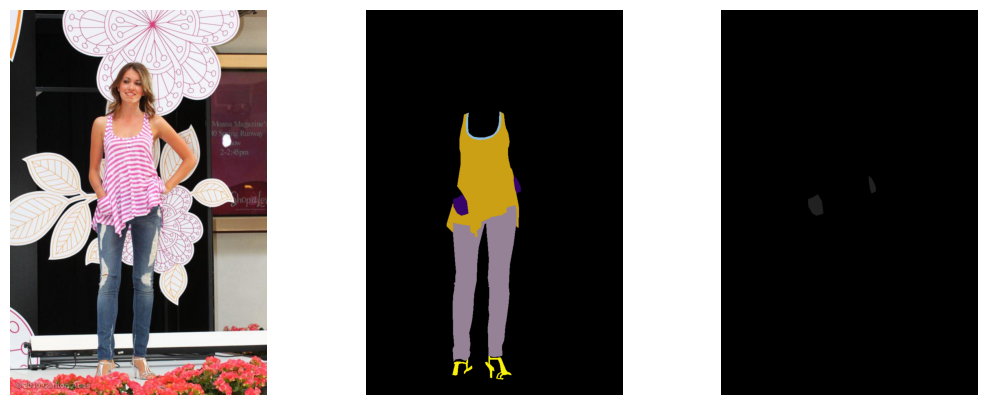

In [13]:
from utils.draw import imshow, mask_to_3D
import cv2 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

# img_id = "0a4d12577220e6024193a9543202453e"
img_id = "9f98c5425e9f04d3c7def0bb2af2771d"
img_id = "83375099c7faa85f0b2b00ad22684847"

for i, (dir, ext) in enumerate([(new_img_dir, ".jpg"), (annotations_dir+"train/", "_seg.png"), (save_dir, "_seg.png")]):

    path = os.path.join(dir, f"{img_id}{ext}")
    img = cv2.imread(path)
    
    # if path.endswith("_seg.png"):
    #     img = mask_to_3D(img, palette)
        
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print(f"Image: {img_id}{ext}", img.ndim)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    imshow(img, ax=ax[i])

### Filter Test and create new data

In [17]:
# ================================================================================================
train_or_val = ['train', 'val'][1]
# ================================================================================================

img_dir = os.path.join(fashion_dir, 'img_dir/'+train_or_val)
json_file = os.path.join(annotations_dir, f"instances_attributes_{train_or_val}2020.json")

# Reduce data to categories with dice below average and area_ratio below 0.3
# ================================================================================================
new_img_dir = os.path.join(data_dir, f'fashionpedia-reduction/img_dir/{train_or_val}/')
new_json_file = os.path.join(new_img_dir, f'annotations-{train_or_val}.json')
reduce_data(json_file, img_dir, new_img_dir, new_json_file, categories=categories)

# Generate masks for reduced data
# ================================================================================================
print("\n" + "="*80)
print(f"Generating masks for {train_or_val} data")
palette = generate_palette(len(classes))
new_annotations_dir =  os.path.join(data_dir, 'fashionpedia-reduction/ann_dir/')

save_dir = os.path.join(new_annotations_dir, train_or_val)
fp = Fashionpedia(new_json_file)
generate_masked_imgs(fp, save_dir, palette, convert_3D=False)


Original JSON file size: 13.86MB (../../_data/fashionpedia/Annotations/instances_attributes_val2020.json)
Filtering data to 23 categories
Reducing data to 658 images...
Original Image-dir size: 234M (../../_data/fashionpedia/test)
Original num. images: 1158
Original Annotations: 8781
New num. images: 658
New Annotations: 1767
Copying images to new folder...
New Image-dir size: 49M (../../_data/fashionpedia-reduction/val/)
New JSON file size: 0.69MB (../../_data/fashionpedia-reduction/val/annotations-val.json)

Generating masks for val data
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading attributes...
attributes index created!
Number of images: 658
Saving files to ../../_data/fashionpedia-reduction/annotations/test
Finished! 658 images processed.


## Filter Train Images

In [ ]:
n_choice = 1000
json_file = train_file
img_dir = img_train_dir
new_img_dir = 'small_data/'
new_json_file = new_img_dir + 'train_small.json'

reduce_data(json_file, img_dir, new_img_dir, new_json_file, n_choice)


Reducing data to 1000 images...
Original Image-dir size: 3.3G (_data/fashionpedia/train/)
Original JSON file size: 517.08MB (_data/fashionpedia/Annotations/instances_attributes_train2020.json)
Copying images to new folder...
New Image-dir size: 526M (small_data/)
New JSON file size: 4.22MB (small_data/train_small.json)
